## Import Necessary Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [7]:
!pip install torchsummary
from torchsummary import summary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Building the Network

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            #input-28x28x1
            # RF - 3x3
            nn.Conv2d(1, 16, 3, bias=False),
            nn.ReLU(),          
            nn.BatchNorm2d(16),  
            nn.Dropout2d(0.1),

            #input-26x26x16
            # RF - 5x5
            nn.Conv2d(16, 16, 3, bias=False),                      
            nn.ReLU(), 
            nn.BatchNorm2d(16),          
            
            #input-24x24x16
            # RF - 7x7
            nn.Conv2d(16, 32, 3, bias=False),            
            nn.ReLU(),         
            nn.BatchNorm2d(32),  
            nn.Dropout2d(0.1),
        )

        
        #Transition block
        self.transition= nn.Sequential(
            #input-22x22x32
            nn.Conv2d(32,16,1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #output=11x11x16
        )      

        self.conv2 = nn.Sequential(
            
            #input=11x11x16
            #RF=16x16
            nn.Conv2d(16, 16, 3, bias=False),           
            nn.ReLU(),          
            nn.BatchNorm2d(16),   
            nn.Dropout2d(0.1), 

            #input=9x9x16
            nn.Conv2d(16, 16, 3, padding=1, bias=False),        
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 16, 3,bias=False),               
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            
            #input=7x7x16
            nn.Conv2d(16,32, 3, bias=False),    
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),        

        )   #output=5x5x32

        # input: 32x5x5
        # output: 32x1x1
        self.conv_final=nn.Conv2d(32, 10, 1, bias=False) 
        self.gap = nn.AvgPool2d(5)            
            

    def forward(self, x):

        x= self.conv1(x)
        x=self.transition(x)
        x= self.conv2(x)      
        x=self.conv_final(x)
        x=self.gap(x)
        x=x.view(-1,10)        
        
        return F.log_softmax(x)

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model=Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
            Conv2d-8           [-1, 32, 22, 22]           4,608
              ReLU-9           [-1, 32, 22, 22]               0
      BatchNorm2d-10           [-1, 32, 22, 22]              64
        Dropout2d-11           [-1, 32, 22, 22]               0
           Conv2d-12           [-1, 16, 22, 22]             528
    

<ipython-input-8-57e2fa97f87c>:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## Preparing the Dataset

In [12]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 96128367.60it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27039217.37it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24715235.69it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22571716.55it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



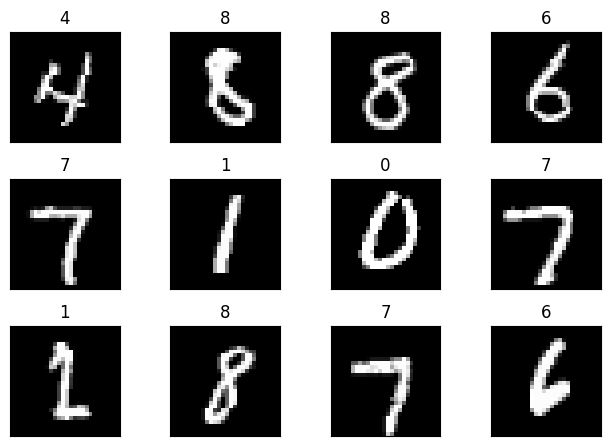

In [13]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

## Training and testing

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [14]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [15]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(1, 20):
    print('\nEpoch {} : '.format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Epoch 1 : 


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-8-57e2fa97f87c>:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.21440552175045013 batch_id=468: 100%|██████████| 469/469 [01:07<00:00,  6.98it/s]



Test set: Average loss: 0.0560, Accuracy: 9829/10000 (98.29%)


Epoch 2 : 


loss=0.050974104553461075 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.39it/s]



Test set: Average loss: 0.0389, Accuracy: 9878/10000 (98.78%)


Epoch 3 : 


loss=0.1348286122083664 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.39it/s]



Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)


Epoch 4 : 


loss=0.07328923791646957 batch_id=468: 100%|██████████| 469/469 [01:04<00:00,  7.33it/s]



Test set: Average loss: 0.0275, Accuracy: 9914/10000 (99.14%)


Epoch 5 : 


loss=0.06996336579322815 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.40it/s]



Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)


Epoch 6 : 


loss=0.0316704697906971 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.38it/s]



Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)


Epoch 7 : 


loss=0.08884567767381668 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.35it/s]



Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)


Epoch 8 : 


loss=0.01366227027028799 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.42it/s]



Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)


Epoch 9 : 


loss=0.04848036542534828 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.39it/s]



Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)


Epoch 10 : 


loss=0.060379188507795334 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.36it/s]



Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)


Epoch 11 : 


loss=0.033541832119226456 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.36it/s]



Test set: Average loss: 0.0189, Accuracy: 9930/10000 (99.30%)


Epoch 12 : 


loss=0.005692657083272934 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.36it/s]



Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)


Epoch 13 : 


loss=0.03460043668746948 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.35it/s]



Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)


Epoch 14 : 


loss=0.08565816283226013 batch_id=468: 100%|██████████| 469/469 [01:04<00:00,  7.32it/s]



Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99.44%)


Epoch 15 : 


loss=0.014360684901475906 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.35it/s]



Test set: Average loss: 0.0169, Accuracy: 9941/10000 (99.41%)


Epoch 16 : 


loss=0.012136665172874928 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.35it/s]



Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)


Epoch 17 : 


loss=0.053760722279548645 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.33it/s]



Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)


Epoch 18 : 


loss=0.01371628325432539 batch_id=468: 100%|██████████| 469/469 [01:04<00:00,  7.27it/s]



Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)


Epoch 19 : 


loss=0.03255043923854828 batch_id=468: 100%|██████████| 469/469 [01:03<00:00,  7.38it/s]



Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

